In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import bisect, brentq
import math

In [2]:
class Contract:
    pass

hw1contract=Contract()
hw1contract.K = 95
hw1contract.T = 0.25
hw1contract.H = 114
hw1contract.observationinterval = 0.02

In [3]:
class Dynamics:
    pass
hw1dynamics=Dynamics()
hw1dynamics.S0 = 100
hw1dynamics.sigma = 0.4
hw1dynamics.r = 0

In [4]:
class Tree:
    pass
hw1tree=Tree()
hw1tree.N=10000

# Question 1
## a)

In [5]:
def barrier_trinom_pricer(dynamics, contract, tree, knock_out = True):
    
    S0, sigma, r = dynamics.S0, dynamics.sigma, dynamics.r
    K, T, H, interval  = contract.K, contract.T, contract.H, contract.observationinterval
    N = tree.N

    deltat =  T/N
    deltax =  sigma*np.sqrt(3*deltat)
    
    S=S0*np.exp(np.linspace(N, -N, num=2*N+1, endpoint=True)*deltax)  
    #Here I decided to make the SMALLER indexes in this array correspond to HIGHER S

    if abs(interval/deltat-round(interval/deltat)) > 1e-12:
        raise ValueError("This value of N fails to place the observation dates in the tree.")

    nu =       r - (sigma**2)/2
    Pu =       0.5*(((sigma**2 * deltat) + nu**2*deltat**2)/(deltax**2)+(nu*deltat)/deltax)
    Pd =       0.5*(((sigma**2 * deltat) + nu**2*deltat**2)/(deltax**2)-(nu*deltat)/deltax)
    Pm =       1-Pu-Pd
        
    optionprice = np.maximum(K-S,0)   #an array of time-T option prices.
        
    #Next, induct backwards to time 0, updating the optionprice array 
    #Hint: if x is an array, then what are x[2:] and x[1:-1] and x[:-2]
    for k in range(N-1,-1,-1):
        t = k*deltat
        for j in range(2*k-1):
            # Check if knock-out option and if we are on one of the discretely-monitered price
            if math.modf(t/interval)[0] < 0.0001 and knock_out is True:
                # calculate stock price for all the nodes of the tree for that time
                S=S0*np.exp(np.linspace(k, -k, num=2*k+1, endpoint=True)*deltax)
                # if stock price higher than the barrier then option price for that node is 0 
                if S[j] > H:
                    optionprice[j] = 0 
                else:
                    up = optionprice[j]
                    mid = optionprice[j+1]
                    down = optionprice[j+2]
                    discount = np.exp(-r*deltat)
                    optionprice[j] = discount*(Pu*up + Pm*mid + Pd*down)
            # How we compute the stock price regularly 
            else:
                up = optionprice[j]
                mid = optionprice[j+1]
                down = optionprice[j+2]
                discount = np.exp(-r*deltat)
                optionprice[j] = discount*(Pu*up + Pm*mid + Pd*down)
        
    return optionprice[0]   
    #The [0] is assuming that we are shrinking the optionprice array in each iteration of the loop,
    #until finally there is only 1 element in the array.
    #If instead you are keeping unchanged the size of the optionprice array in each iteration, 
    #then you need to change the [0] to a different index.

price_knockout = barrier_trinom_pricer(hw1dynamics, hw1contract, hw1tree)
print("Price of knock-out put option is : {:.4f}".format(price_knockout))

Monitered Price at time:  0.24000000000000002
Monitered Price at time:  0.22
Monitered Price at time:  0.2
Monitered Price at time:  0.18000000000000002
Monitered Price at time:  0.16
Monitered Price at time:  0.14
Monitered Price at time:  0.12000000000000001
Monitered Price at time:  0.1
Monitered Price at time:  0.08
Monitered Price at time:  0.060000000000000005
Monitered Price at time:  0.04
Monitered Price at time:  0.02
Price of knock-out put option is : 5.1596


## b)
Given that the price of a knock-in put option plus the price of a knock-out put option should be equal to the price of a regular put options we have 

In [6]:
price_put = barrier_trinom_pricer(hw1dynamics, hw1contract, hw1tree, knock_out = False)
price_knockin = price_put - price_knockout
print("Price of knock-in put option is : {:.4f}".format(price_knockin))

Price of knock-in put option is : 0.2355


## c)

### c1) 
The time-0 price of the continuously-monitored barrier option will be smaller than the time-0 price of the discretely-monitered option because on top of adding constraints on the potential stock paths that results in a non-zero option price we are checking whether the stock price is above the barrier at same time than the discrete those. In other terms, the continuously-monitored barrier option is the discretely-monitered option + the added constraints that between the intervals if the stock price goes higher than the barrier than the resulting option price is 0. We are thus adding constraints that reduces the amounts of stock paths that result in a non-zero payout so the price needs to be lower. 

### c2)

We require that $P(K=95,T=t) = \alpha \cdot C(K=136.8, T=t) \; \forall t\in[0,0.25]$ this is solvable since we have that $r=0$ in this framework. We will solve this by solving the value of both options whenever S = 114. Since this needs to work $\forall t\in[0,0.25]$, we can solve it for $t=0$.

$$ K\cdot N(-d_2^p) - S_0 \cdot N(-d_1^p)= \alpha\left(S_0 \cdot N(d_1^c) - K \cdot N(d_2^c)\right) $$
$$ 95\cdot N(-d_2^p) - 114 \cdot N(-d_1^p)= \alpha\left(114 \cdot N(d_1^c) - 136.8 \cdot N(d_2^c)\right) $$

Note that 
$$\log\left(\frac{114}{136.8}\right) = -\log\left(\frac{114}{95}\right) $$

$$ d_1^p = \frac{\log\left(\frac{114}{95}\right)}{0.4\cdot\sqrt{T}} + \frac{0.4\cdot\sqrt{T}}{2} = - \left(\frac{\log\left(\frac{136.8}{114}\right)}{0.4\cdot\sqrt{T}} - \frac{0.4\cdot\sqrt{T}}{2}\right) = -d_2^c $$

$$ d_1^c = \frac{\log\left(\frac{136.8}{114}\right)}{0.4\cdot\sqrt{T}} + \frac{0.4\cdot\sqrt{T}}{2} = - \left(\frac{\log\left(\frac{114}{95}\right)}{0.4\cdot\sqrt{T}} - \frac{0.4\cdot\sqrt{T}}{2}\right) = -d_2^p $$

$$ 95\cdot N(d_1^c) - 114 \cdot N(d_2^c)= \alpha\left(114 \cdot N(d_1^c) - 136.8 \cdot N(d_2^c)\right) $$

$$ \therefore \alpha = \frac{95}{114} = \frac{114}{136.8} = \frac{5}{6} $$

# Question 2)

## a) 

One could find a continuous function $\sigma(t)$ such that the $\sigma$ varies along time to fit observable data in the market. Replacing the standard $\sigma$ by this $\sigma(t)$ in the classic stock price dynamics under BS model $dS_t = rS_tdt + \sigma(t)S_tdW_t$ could explain the term-structure of implied volatility. But, in reality we not only observe a change of volatility over time but also a change of volatility of strike prices. The combination of both shapes the structure of the surface volatility. In order to account for that dimension, we would require that our volatility function be also a parameter of the strike price $K$ such that $\sigma(t) \rightarrow \sigma(t,K)$.

## b)

In [7]:
def BScallPrice(sigma,S,rGrow,r,K,T):
    F=S*np.exp(rGrow*T)
    sd = sigma*np.sqrt(T)
    d1 = np.log(F/K)/sd+sd/2
    d2 = d1-sd
    return np.exp(-r*T)*(F*norm.cdf(d1)-K*norm.cdf(d2))

In [8]:
def IVofCall(C,S,rGrow,r,K,T):
    F=S*np.exp(rGrow*T)
    lowerbound = np.max([0,(F-K)*np.exp(-r*T)])
    if C<lowerbound:
        return np.nan
    if C==lowerbound:
        return 0
    if C>=F*np.exp(-r*T):
        return np.nan 
    hi=0.2
    while BScallPrice(hi,S,rGrow,r,K,T)>C:
        hi=hi/2
    while BScallPrice(hi,S,rGrow,r,K,T)<C:
        hi=hi*2
    lo=hi/2
    
    vol = hi
    while abs(BScallPrice(vol,S,rGrow,r,K,T)-C) > 0.0001:
        vol = (lo + hi)/2 
        if BScallPrice(vol,S,rGrow,r,K,T) > C:
            hi = vol
        else:
            lo = vol
    
    impliedVolatility = vol 
                            
    return impliedVolatility

In [9]:
T = [0.1, 0.2, 0.5]
C = [5.25, 7.25, 9.5]
sigma = []

for i in range(len(T)):
    sigma.append(IVofCall(C[i], 100, 0.05,0.05,100,T[i]))
    print("B-S implied volatility for an ATM Call Option with Expiry Time={:.1f} is equal to: {:.4f}".format(T[i], sigma[i]))

B-S implied volatility for an ATM Call Option with Expirty Time=0.1 is equal to: 0.3973
B-S implied volatility for an ATM Call Option with Expirty Time=0.2 is equal to: 0.3802
B-S implied volatility for an ATM Call Option with Expirty Time=0.5 is equal to: 0.2951


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

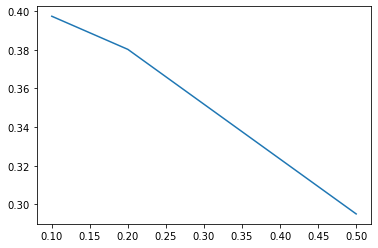

In [11]:
pd.Series(sigma, index = T).plot()
plt.show()

Based on the above graph, we can assume a linear regression would work well for values between 0 and 0.5. 

In [12]:
slope, intercept, r_value, p_value, std_err = stats.linregress(T,sigma)

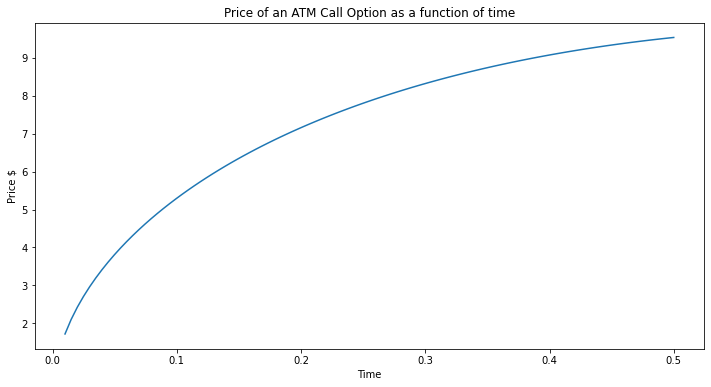

In [13]:
t = np.linspace(0.01,0.5,100)
local_sig = intercept + slope*t
call_prices = []
for i in range(len(t)):
    call_prices.append(BScallPrice(local_sig[i],100,0.05,0.05,100,t[i]))
call_prices = pd.Series(call_prices, index = t)
ax = call_prices.plot(title = 'Price of an ATM Call Option as a function of time', figsize = (12,6))
ax.set_xlabel("Time")
ax.set_ylabel("Price $")
plt.show()

## c)


In [14]:
sigma = intercept + slope*0.4
print("Time-0 price of an ATM European Call with expiry T=0.4 is {:.4f}".format(BScallPrice(sigma,100,0.05,0.05,100,0.4)))

Time-0 price of an ATM European Call with expiry T=0.4 is 9.0735
